In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import MDAnalysis as mda
import seaborn as sns
from seaborn import kdeplot
from pylab import cm
from tqdm import tqdm


In [2]:
import pandas as pd
import os,sys
sys.path.append('../../scripts/')
sys.path.append('../../plot_styles/')
sys.path.append('../../data/')


In [3]:
#######PLOTTING PARAMS########
plt.rcParams['figure.dpi'] = 400
plt.figure(figsize=(10, 30))
plt.rc("axes",linewidth=4)
plt.rc("legend",fontsize=10,frameon=False)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = "serif"
tdir = 'in'
major = 5.0
minor = 3.0
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.savefig('my_plot.png', dpi=400)  # Save with DPI of 400

<Figure size 4000x12000 with 0 Axes>

In [4]:
label = np.array(['HIA', 'OB', 'p-gp inhibitor', 'p-gp substrates', 'BBB',
       'Respiratory toxicity', 'Hepatotoxicity', 'half-life', 'CL',
       'Cardiotoxicity1', 'Cardiotoxicity10', 'Cardiotoxicity30',
       'Cardiotoxicity5', 'CYP1A2', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4',
       'Acute oral toxicity (LD50)', 'IGC50', 'ESOL', 'logD',
       'Caco-2 permeability', 'PPB'])
binary = np.array([True]*18 + [False]*6)

In [5]:
data = np.loadtxt("../../data/embeddings_features.dat", delimiter = " ")
RS = 212

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
features = data[:,-24:]
m = StandardScaler()
m.fit(features[:,~binary])
features[:,-6:] = m.transform(features[:,~binary])
data[:,-24:] = features

In [7]:

from sklearn.model_selection import train_test_split
# Step 1: Split into 80% training and 20% temporary set
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=RS)

# Step 2: Split the temporary set into 50% validation and 50% testing (each will be 10% of the original data)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RS)

In [8]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

35987
4498
4499


In [9]:
train_data = train_df[:,:-24]
val_data = val_df[:,:-24]
test_data = test_df[:,:-24]
train_label = train_df[:,-24:]
val_label = val_df[:,-24:]
test_label = test_df[:,-24:]

In [10]:
print(train_data.shape)

(35987, 512)


In [11]:
i=21
train_label[:,i][~np.isnan(train_label[:,i])]

array([ 5.89215871e-01, -1.26399231e+00, -7.54606747e-02,  1.04790633e-01,
       -1.58506485e+00, -5.29292120e-02,  1.38908069e+00,  1.38908069e+00,
       -8.41528437e-01,  1.22009519e+00,  1.07364105e+00, -1.26156283e-01,
       -2.55711870e-01, -1.37421986e-01,  2.02978589e-02, -1.37664934e+00,
       -1.59953392e-01,  3.41370401e-01, -3.60306571e-02,  1.38344800e+00,
       -3.12040386e-01, -1.03624876e-01, -2.29480421e+00,  5.66684465e-01,
        1.71015334e+00,  3.71964138e-02, -3.51470291e-01, -1.11190531e+00,
       -9.42919766e-01, -6.16214361e-01, -3.03978055e-02,  6.56810034e-01,
        1.11307113e+00,  1.73268475e+00,  1.12996963e+00, -3.03978055e-02,
        9.60984134e-01,  7.97631324e-01,  4.03331825e-01, -1.31789134e-01,
        1.25389242e+00,  2.14388291e+00,  5.97278202e-02,  1.01731259e+00,
       -7.28871399e-01, -1.19639809e+00, -1.29215658e+00,  5.66684465e-01,
        2.70716808e+00, -1.65586244e-01,  3.41370401e-01, -3.34571792e-01,
        1.00604689e+00, -

In [12]:
from mtan_admet import MultiTaskModel

In [13]:
# usage:
input_size = 512 #seq2seq
shared_str = [128]
ntasks = 24
dedicated_str = [64,16]
duplicate = True
epochs = 50
batch_size = 512
k=4
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_label)
label = ['HIA', 'OB', 'p-gp inhibitor', 'p-gp substrates', 'BBB',
       'Respiratory toxicity', 'Hepatotoxicity', 'half-life', 'CL',
       'Cardiotoxicity1', 'Cardiotoxicity10', 'Cardiotoxicity30',
       'Cardiotoxicity5', 'CYP1A2', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4',
       'Acute oral toxicity (LD50)', 'IGC50', 'ESOL', 'logD',
       'Caco-2 permeability', 'PPB']
binary = np.array([True]*18 + [False]*6)
benchmark = np.array([0.981,0.749,0.928,0.801,0.973,0.859,0.701,0.727,0.779,0.740,0.654,0.723,0.641,0.95,0.804,0.794,0.869,0.916,0.635,0.819,0.931,0.915,0.523,0.626])
val_data = torch.Tensor(val_data)
val_labels = torch.Tensor(val_label)

In [14]:
model = MultiTaskModel(input_size, train_data, val_data, train_labels, val_labels, epochs, batch_size, shared_str, dedicated_str, ntasks,binary,label,benchmark = benchmark,k=k, thresh =0.0001, duplicate=duplicate)
improved_tasks = model.Fit()

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.3853       0.8357     nan        0.1133       0.9173     nan       0.9810    
Task 2  0.5648       0.6809     nan        0.3900       0.6640     nan       0.7490    
Task 3  0.6187       0.8847     nan        0.4933       0.8820     nan       0.9280    
Task 4  0.5952       0.6681     nan        0.5350       0.7273     nan       0.8010    
Task 5  0.5011       0.8515     nan        0.3328       0.7693     nan       0.9730    
Task 6  0.6370       0.6453     nan        0.5939       0.6837     nan       0.8590    
Task 7  0.6444       0.5185     nan        0.6243       0.5734     nan       0.7010    
Task 8  0.6433       0.6599     nan        0.6123       0.6663     nan       0.7270    
Task 9  0.6464       0.6396     nan        0.6476       0.6330     nan       0.7790    
Task 10 0.5624       0.5803     nan        0.5161       0.4562     nan       0.7400    
Task 11 0.6568      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.1810       0.8970     nan        0.1043       0.9380     nan       0.9810    
Task 2  0.4776       0.7090     nan        0.4051       0.6056     nan       0.7490    
Task 3  0.4619       0.9032     nan        0.3469       0.8889     nan       0.9280    
Task 4  0.5765       0.7042     nan        0.5274       0.7218     nan       0.8010    
Task 5  0.3458       0.8937     nan        0.2825       0.8128     nan       0.9730    
Task 6  0.6237       0.6863     nan        0.5764       0.7171     nan       0.8590    
Task 7  0.6356       0.5742     nan        0.6240       0.6220     nan       0.7010    
Task 8  0.5898       0.6902     nan        0.6030       0.6735     nan       0.7270    
Task 9  0.6339       0.6625     nan        0.6271       0.6796     nan       0.7790    
Task 10 0.4725       0.7558     nan        0.4707       0.6512     nan       0.7400    
Task 11 0.6187      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 3/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.1669       0.9307     nan        0.0670       0.9267     nan       0.9810    
Task 2  0.4530       0.7618     nan        0.3922       0.6482     nan       0.7490    
Task 3  0.3605       0.9148     nan        0.3168       0.8900     nan       0.9280    
Task 4  0.5267       0.7337     nan        0.4825       0.7289     nan       0.8010    
Task 5  0.2917       0.9194     nan        0.2300       0.8525     nan       0.9730    
Task 6  0.5626       0.7384     nan        0.5015       0.7648     nan       0.8590    
Task 7  0.5935       0.5977     nan        0.5829       0.6186     nan       0.7010    
Task 8  0.5598       0.7064     nan        0.5580       0.6912     nan       0.7270    
Task 9  0.5823       0.6876     nan        0.5741       0.6969     nan       0.7790    
Task 10 0.4107       0.7926     nan        0.4219       0.7095     nan       0.7400    
Task 11 0.5727      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 4/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.1379       0.9516     nan        0.0518       0.9286     nan       0.9810    
Task 2  0.4183       0.7891     nan        0.3717       0.6675     nan       0.7490    
Task 3  0.3596       0.9261     nan        0.3019       0.8958     nan       0.9280    
Task 4  0.5224       0.7661     nan        0.4864       0.7218     nan       0.8010    
Task 5  0.2537       0.9349     nan        0.2136       0.8703     nan       0.9730    
Task 6  0.5194       0.7870     nan        0.4500       0.8056     nan       0.8590    
Task 7  0.6034       0.6330     nan        0.5861       0.6091     nan       0.7010    
Task 8  0.5285       0.7267     nan        0.5514       0.7069     nan       0.7270    
Task 9  0.5650       0.7076     nan        0.5565       0.7164     nan       0.7790    
Task 10 0.3926       0.8406     nan        0.4008       0.7578     nan       0.7400    
Task 11 0.5427      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 5/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0932       0.9722     nan        0.0496       0.9286     nan       0.9810    
Task 2  0.4021       0.8066     nan        0.4014       0.6944     nan       0.7490    
Task 3  0.3370       0.9309     nan        0.2923       0.8998     nan       0.9280    
Task 4  0.4694       0.7868     nan        0.4808       0.7147     nan       0.8010    
Task 5  0.2291       0.9480     nan        0.2033       0.8883     nan       0.9730    
Task 6  0.4878       0.8596     nan        0.4293       0.8424     nan       0.8590    
Task 7  0.5870       0.6238     nan        0.5817       0.6163     nan       0.7010    
Task 8  0.5292       0.7490     nan        0.5452       0.7056     nan       0.7270    
Task 9  0.5393       0.7427     nan        0.5515       0.7130     nan       0.7790    
Task 10 0.3619       0.8658     nan        0.3882       0.7706     nan       0.7400    
Task 11 0.5285      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 6/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0561       0.9793     nan        0.0457       0.9229     nan       0.9810    
Task 2  0.3833       0.8420     nan        0.3814       0.7371     nan       0.7490    
Task 3  0.3251       0.9379     nan        0.2974       0.9025     nan       0.9280    
Task 4  0.4469       0.8165     nan        0.5003       0.6879     nan       0.8010    
Task 5  0.2120       0.9541     nan        0.2171       0.8831     nan       0.9730    
Task 6  0.4306       0.8844     nan        0.4103       0.8587     nan       0.8590    
Task 7  0.5774       0.6466     nan        0.5810       0.6278     nan       0.7010    
Task 8  0.4995       0.7687     nan        0.5319       0.7265     nan       0.7270    
Task 9  0.5209       0.7734     nan        0.5422       0.7343     nan       0.7790    
Task 10 0.3399       0.8875     nan        0.3890       0.8220     nan       0.7400    
Task 11 0.4936      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 7/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          0.9835     nan        0.0532       0.9192     nan       0.9810    
Task 2  0.3757       0.8652     nan        0.3680       0.7260     nan       0.7490    
Task 3  0.2981       0.9436     nan        0.2957       0.8999     nan       0.9280    
Task 4  0.4434       0.8403     nan        0.5048       0.6903     nan       0.8010    
Task 5  0.1979       0.9614     nan        0.2098       0.8825     nan       0.9730    
Task 6  0.4256       0.8991     nan        0.3909       0.8507     nan       0.8590    
Task 7  0.5928       0.6672     nan        0.5806       0.6197     nan       0.7010    
Task 8  0.4883       0.8005     nan        0.5050       0.7529     nan       0.7270    
Task 9  0.5091       0.8081     nan        0.5387       0.7401     nan       0.7790    
Task 10 0.3448       0.9085     nan        0.4043       0.8033     nan       0.7400    
Task 11 0.4668      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 8/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0117       0.9920     nan        0.0380       0.9380     nan       0.9810    
Task 2  0.3423       0.8809     nan        0.3983       0.7307     nan       0.7490    
Task 3  0.3020       0.9478     nan        0.2947       0.9095     nan       0.9280    
Task 4  0.4044       0.8584     nan        0.5200       0.6706     nan       0.8010    
Task 5  0.1938       0.9650     nan        0.2132       0.8994     nan       0.9730    
Task 6  0.3858       0.9136     nan        0.3692       0.8602     nan       0.8590    
Task 7  0.5738       0.6895     nan        0.5885       0.5996     nan       0.7010    
Task 8  0.4766       0.8286     nan        0.4866       0.7690     nan       0.7270    
Task 9  0.5033       0.8269     nan        0.5329       0.7460     nan       0.7790    
Task 10 0.2926       0.9209     nan        0.3941       0.7980     nan       0.7400    
Task 11 0.4478      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 9/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0087       0.9943     nan        0.0072       0.9323     nan       0.9810    
Task 2  0.3133       0.8842     nan        0.4130       0.6810     nan       0.7490    
Task 3  0.2891       0.9534     nan        0.2839       0.9112     nan       0.9280    
Task 4  0.4017       0.8696     nan        0.5376       0.6777     nan       0.8010    
Task 5  0.1764       0.9706     nan        0.2057       0.9065     nan       0.9730    
Task 6  0.3798       0.9270     nan        0.3525       0.8758     nan       0.8590    
Task 7  0.5770       0.7075     nan        0.5849       0.6051     nan       0.7010    
Task 8  0.4634       0.8529     nan        0.4612       0.7810     nan       0.7270    
Task 9  0.4550       0.8539     nan        0.5408       0.7392     nan       0.7790    
Task 10 0.2852       0.9349     nan        0.3918       0.8075     nan       0.7400    
Task 11 0.4304      

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 10/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0146      0.9939     nan        0.0270       0.9380     nan       0.9810    
Task 2  0.3246       0.9170     nan        0.3702       0.7523     nan       0.7490    
Task 3  0.2752       0.9546     nan        0.3061       0.9050     nan       0.9280    
Task 4  0.4019       0.8995     nan        0.5089       0.6840     nan       0.8010    
Task 5  0.1598       0.9750     nan        0.2134       0.9038     nan       0.9730    
Task 6  0.3540       0.9343     nan        0.3424       0.8807     nan       0.8590    
Task 7  0.5659       0.7152     nan        0.5814       0.6306     nan       0.7010    
Task 8  0.4457       0.8715     nan        0.4928       0.7817     nan       0.7270    
Task 9  0.4361       0.8727     nan        0.5418       0.7315     nan       0.7790    
Task 10 0.2639       0.9388     nan        0.3628       0.8114     nan       0.7400    
Task 11 0.4287     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 11/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0131      0.9974     nan        0.0152       0.9436     nan       0.9810    
Task 2  0.2812       0.9237     nan        0.3726       0.7424     nan       0.7490    
Task 3  0.2648       0.9584     nan        0.3103       0.9048     nan       0.9280    
Task 4  0.3562       0.9089     nan        0.4755       0.7108     nan       0.8010    
Task 5  0.1597       0.9772     nan        0.2065       0.9067     nan       0.9730    
Task 6  0.3471       0.9434     nan        0.3460       0.8781     nan       0.8590    
Task 7  0.5597       0.7297     nan        0.5835       0.6194     nan       0.7010    
Task 8  0.4179       0.8843     nan        0.4696       0.7856     nan       0.7270    
Task 9  0.4302       0.8792     nan        0.5693       0.7343     nan       0.7790    
Task 10 0.2596       0.9510     nan        0.3871       0.8002     nan       0.7400    
Task 11 0.3773     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 12/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0129      0.9993     nan        0.0404       0.9135     nan       0.9810    
Task 2  0.2795       0.9367     nan        0.4228       0.7266     nan       0.7490    
Task 3  0.2634       0.9628     nan        0.3094       0.9070     nan       0.9280    
Task 4  0.3478       0.9239     nan        0.4882       0.7124     nan       0.8010    
Task 5  0.1618       0.9794     nan        0.2031       0.9122     nan       0.9730    
Task 6  0.3246       0.9521     nan        0.3592       0.8740     nan       0.8590    
Task 7  0.5633       0.7474     nan        0.5816       0.6197     nan       0.7010    
Task 8  0.3995       0.8923     nan        0.4587       0.7712     nan       0.7270    
Task 9  0.4159       0.9132     nan        0.5402       0.7265     nan       0.7790    
Task 10 0.2341       0.9589     nan        0.4001       0.8225     nan       0.7400    
Task 11 0.3627     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 13/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0265      0.9981     nan        0.0411       0.9342     nan       0.9810    
Task 2  0.2494       0.9413     nan        0.4316       0.7284     nan       0.7490    
Task 3  0.2580       0.9640     nan        0.3118       0.9075     nan       0.9280    
Task 4  0.3204       0.9440     nan        0.5288       0.6722     nan       0.8010    
Task 5  0.1490       0.9812     nan        0.2103       0.9062     nan       0.9730    
Task 6  0.2991       0.9595     nan        0.3383       0.8773     nan       0.8590    
Task 7  0.5445       0.7614     nan        0.5869       0.6140     nan       0.7010    
Task 8  0.3774       0.9047     nan        0.4559       0.7905     nan       0.7270    
Task 9  0.3931       0.9229     nan        0.5539       0.7448     nan       0.7790    
Task 10 0.2273       0.9596     nan        0.3739       0.8122     nan       0.7400    
Task 11 0.3642     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 14/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0047      0.9978     nan        0.0550       0.9455     nan       0.9810    
Task 2  0.2479       0.9568     nan        0.3979       0.7260     nan       0.7490    
Task 3  0.2573       0.9660     nan        0.2873       0.9131     nan       0.9280    
Task 4  0.2844       0.9400     nan        0.4945       0.7171     nan       0.8010    
Task 5  0.1503       0.9836     nan        0.2010       0.9162     nan       0.9730    
Task 6  0.2847       0.9645     nan        0.3595       0.8631     nan       0.8590    
Task 7  0.5448       0.7640     nan        0.5872       0.6134     nan       0.7010    
Task 8  0.3918       0.9094     nan        0.4687       0.7925     nan       0.7270    
Task 9  0.3607       0.9383     nan        0.5644       0.7188     nan       0.7790    
Task 10 0.2137       0.9691     nan        0.3904       0.8287     nan       0.7400    
Task 11 0.3424     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 15/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0558      0.9994     nan        0.0554       0.9117     nan       0.9810    
Task 2  0.2425       0.9646     nan        0.3970       0.7371     nan       0.7490    
Task 3  0.2509       0.9688     nan        0.3005       0.9103     nan       0.9280    
Task 4  0.2553       0.9548     nan        0.4687       0.7273     nan       0.8010    
Task 5  0.1334       0.9856     nan        0.2002       0.9168     nan       0.9730    
Task 6  0.2696       0.9717     nan        0.3442       0.8750     nan       0.8590    
Task 7  0.5356       0.7860     nan        0.5872       0.6163     nan       0.7010    
Task 8  0.3576       0.9332     nan        0.4809       0.7895     nan       0.7270    
Task 9  0.3345       0.9407     nan        0.5553       0.7358     nan       0.7790    
Task 10 0.2089       0.9717     nan        0.3995       0.8172     nan       0.7400    
Task 11 0.3357     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 16/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          0.9987     nan        0.0146       0.9455     nan       0.9810    
Task 2  0.1882       0.9611     nan        0.4140       0.7272     nan       0.7490    
Task 3  0.2241       0.9718     nan        0.3140       0.9079     nan       0.9280    
Task 4  nan          0.9634     nan        0.5041       0.7116     nan       0.8010    
Task 5  0.1369       0.9873     nan        0.2003       0.9156     nan       0.9730    
Task 6  0.2568       0.9714     nan        0.3706       0.8678     nan       0.8590    
Task 7  0.5281       0.7983     nan        0.5758       0.6260     nan       0.7010    
Task 8  0.3225       0.9385     nan        0.4459       0.8059     nan       0.7270    
Task 9  0.3259       0.9496     nan        0.6014       0.7355     nan       0.7790    
Task 10 0.1878       0.9770     nan        0.3884       0.8223     nan       0.7400    
Task 11 0.3173     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 17/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0345      1.0000     nan        0.0375       0.9098     nan       0.9810    
Task 2  0.1937       0.9740     nan        0.4617       0.7254     nan       0.7490    
Task 3  0.2267       0.9732     nan        0.3149       0.9092     nan       0.9280    
Task 4  nan          0.9692     nan        0.5651       0.7037     nan       0.8010    
Task 5  0.1213       0.9880     nan        0.2147       0.9122     nan       0.9730    
Task 6  0.2401       0.9732     nan        0.3805       0.8628     nan       0.8590    
Task 7  0.5070       0.8211     nan        0.5921       0.6186     nan       0.7010    
Task 8  0.3276       0.9536     nan        0.4643       0.7977     nan       0.7270    
Task 9  0.3106       0.9630     nan        0.6031       0.7225     nan       0.7790    
Task 10 0.1639       0.9784     nan        0.4378       0.8075     nan       0.7400    
Task 11 0.2929     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 18/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0521      0.9999     nan        0.0579       0.9305     nan       0.9810    
Task 2  0.1924       0.9756     nan        0.4358       0.7371     nan       0.7490    
Task 3  0.2176       0.9765     nan        0.3111       0.9108     nan       0.9280    
Task 4  0.1771       0.9716     nan        0.5621       0.7116     nan       0.8010    
Task 5  0.1108       0.9884     nan        0.2228       0.9158     nan       0.9730    
Task 6  0.2222       0.9796     nan        0.3403       0.8910     nan       0.8590    
Task 7  0.4940       0.8359     nan        0.5905       0.6249     nan       0.7010    
Task 8  0.3086       0.9620     nan        0.5148       0.7814     nan       0.7270    
Task 9  0.2892       0.9655     nan        0.5931       0.7475     nan       0.7790    
Task 10 0.1755       0.9829     nan        0.3951       0.8278     nan       0.7400    
Task 11 0.2912     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 19/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0598      0.9999     nan        0.0882       0.8759     nan       0.9810    
Task 2  0.1654       0.9816     nan        0.4387       0.7447     nan       0.7490    
Task 3  0.2156       0.9767     nan        0.3135       0.9092     nan       0.9280    
Task 4  0.1561       0.9800     nan        0.6120       0.6958     nan       0.8010    
Task 5  0.1195       0.9889     nan        0.2346       0.9074     nan       0.9730    
Task 6  0.2241       0.9832     nan        0.3615       0.8789     nan       0.8590    
Task 7  0.5016       0.8402     nan        0.5947       0.6166     nan       0.7010    
Task 8  0.2822       0.9692     nan        0.5562       0.7869     nan       0.7270    
Task 9  0.2559       0.9734     nan        0.6425       0.7324     nan       0.7790    
Task 10 0.1522       0.9831     nan        0.4591       0.7974     nan       0.7400    
Task 11 0.2618     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 20/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          0.9998     nan        0.0997       0.8741     nan       0.9810    
Task 2  0.1431       0.9863     nan        0.4588       0.7354     nan       0.7490    
Task 3  0.2042       0.9765     nan        0.3278       0.9118     nan       0.9280    
Task 4  0.1798       0.9860     nan        0.4868       0.7400     nan       0.8010    
Task 5  0.0956       0.9904     nan        0.2271       0.9126     nan       0.9730    
Task 6  0.1800       0.9863     nan        0.3934       0.8711     nan       0.8590    
Task 7  0.4928       0.8586     nan        0.6036       0.5944     nan       0.7010    
Task 8  0.2721       0.9708     nan        0.5221       0.7863     nan       0.7270    
Task 9  0.2432       0.9735     nan        0.6330       0.7383     nan       0.7790    
Task 10 0.1526       0.9852     nan        0.4175       0.8306     nan       0.7400    
Task 11 0.2588     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 21/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0522      1.0000     nan        0.0837       0.8853     nan       0.9810    
Task 2  0.1412       0.9854     nan        0.5160       0.7237     nan       0.7490    
Task 3  0.2146       0.9788     nan        0.3239       0.9093     nan       0.9280    
Task 4  0.1530       0.9829     nan        0.5802       0.7407     nan       0.8010    
Task 5  0.0999       0.9913     nan        0.2543       0.9097     nan       0.9730    
Task 6  0.1808       0.9861     nan        0.4088       0.8709     nan       0.8590    
Task 7  0.4536       0.8548     nan        0.5997       0.6125     nan       0.7010    
Task 8  0.2490       0.9763     nan        0.5262       0.7797     nan       0.7270    
Task 9  0.2308       0.9791     nan        0.6347       0.7401     nan       0.7790    
Task 10 0.1666       0.9881     nan        0.4378       0.8150     nan       0.7400    
Task 11 0.2246     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 22/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0651      0.9990     nan        0.1177       0.8440     nan       0.9810    
Task 2  0.1404       0.9886     nan        0.4778       0.7243     nan       0.7490    
Task 3  0.2085       0.9802     nan        0.3345       0.9053     nan       0.9280    
Task 4  0.1648       0.9882     nan        0.5576       0.7305     nan       0.8010    
Task 5  0.0965       0.9921     nan        0.2405       0.9122     nan       0.9730    
Task 6  0.1788       0.9884     nan        0.4185       0.8672     nan       0.8590    
Task 7  0.4760       0.8800     nan        0.6131       0.5778     nan       0.7010    
Task 8  0.2492       0.9805     nan        0.5787       0.7827     nan       0.7270    
Task 9  0.1997       0.9849     nan        0.7055       0.7321     nan       0.7790    
Task 10 0.1306       0.9890     nan        0.4633       0.8281     nan       0.7400    
Task 11 0.2418     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 23/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0662      0.9993     nan        0.1200       0.8459     nan       0.9810    
Task 2  nan          0.9919     nan        0.5370       0.7091     nan       0.7490    
Task 3  0.1896       0.9825     nan        0.3494       0.9033     nan       0.9280    
Task 4  0.1249       0.9913     nan        0.5108       0.7439     nan       0.8010    
Task 5  0.0940       0.9923     nan        0.2524       0.9096     nan       0.9730    
Task 6  0.1299       0.9893     nan        0.4772       0.8574     nan       0.8590    
Task 7  0.4450       0.8949     nan        0.6260       0.5933     nan       0.7010    
Task 8  0.2382       0.9790     nan        0.5995       0.7843     nan       0.7270    
Task 9  0.2252       0.9864     nan        0.7662       0.7204     nan       0.7790    
Task 10 0.1140       0.9914     nan        0.4799       0.8175     nan       0.7400    
Task 11 0.2225     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 24/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0754      0.9995     nan        0.1047       0.8797     nan       0.9810    
Task 2  0.1238       0.9921     nan        0.5087       0.7249     nan       0.7490    
Task 3  0.1802       0.9835     nan        0.3395       0.9089     nan       0.9280    
Task 4  0.1571       0.9910     nan        0.5603       0.7155     nan       0.8010    
Task 5  0.1068       0.9931     nan        0.2420       0.9150     nan       0.9730    
Task 6  0.1370       0.9909     nan        0.4371       0.8703     nan       0.8590    
Task 7  0.4391       0.8884     nan        0.6013       0.6283     nan       0.7010    
Task 8  0.2217       0.9848     nan        0.5787       0.7660     nan       0.7270    
Task 9  0.1774       0.9910     nan        0.7004       0.7423     nan       0.7790    
Task 10 0.1069       0.9915     nan        0.5411       0.8147     nan       0.7400    
Task 11 0.2254     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 25/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0677      0.9998     nan        0.0717       0.9023     nan       0.9810    
Task 2  0.0902       0.9951     nan        0.5109       0.7266     nan       0.7490    
Task 3  0.1703       0.9855     nan        0.3425       0.9065     nan       0.9280    
Task 4  nan          0.9944     nan        0.6058       0.7384     nan       0.8010    
Task 5  0.0837       0.9941     nan        0.2611       0.9072     nan       0.9730    
Task 6  0.1439       0.9932     nan        0.4800       0.8595     nan       0.8590    
Task 7  0.4308       0.9052     nan        0.6752       0.5677     nan       0.7010    
Task 8  0.2155       0.9864     nan        0.6269       0.7788     nan       0.7270    
Task 9  0.1799       0.9913     nan        0.7187       0.7580     nan       0.7790    
Task 10 0.1138       0.9938     nan        0.4751       0.8301     nan       0.7400    
Task 11 0.2219     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 26/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0835      0.9999     nan        0.0685       0.9098     nan       0.9810    
Task 2  0.0743       0.9943     nan        0.5452       0.7360     nan       0.7490    
Task 3  0.1718       0.9858     nan        0.3741       0.9033     nan       0.9280    
Task 4  0.0551       0.9944     nan        0.6684       0.7258     nan       0.8010    
Task 5  0.0931       0.9943     nan        0.2465       0.9076     nan       0.9730    
Task 6  0.1181       0.9914     nan        0.5507       0.8491     nan       0.8590    
Task 7  0.4115       0.9172     nan        0.6400       0.6005     nan       0.7010    
Task 8  0.2127       0.9869     nan        0.7261       0.7693     nan       0.7270    
Task 9  0.1455       0.9946     nan        0.7970       0.7336     nan       0.7790    
Task 10 0.0974       0.9952     nan        0.4393       0.8259     nan       0.7400    
Task 11 0.2110     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 27/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0901      1.0000     nan        0.1029       0.9060     nan       0.9810    
Task 2  0.0803       0.9960     nan        0.6179       0.7213     nan       0.7490    
Task 3  0.1674       0.9869     nan        0.3533       0.9050     nan       0.9280    
Task 4  0.0751       0.9968     nan        0.7003       0.7155     nan       0.8010    
Task 5  0.0881       0.9948     nan        0.2438       0.9174     nan       0.9730    
Task 6  0.1386       0.9946     nan        0.4695       0.8561     nan       0.8590    
Task 7  0.3984       0.9185     nan        0.6538       0.6134     nan       0.7010    
Task 8  0.1964       0.9892     nan        0.6604       0.7660     nan       0.7270    
Task 9  0.1502       0.9935     nan        0.7832       0.7398     nan       0.7790    
Task 10 0.1111       0.9957     nan        0.4468       0.8362     nan       0.7400    
Task 11 0.1982     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 28/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          1.0000     nan        0.0607       0.9192     nan       0.9810    
Task 2  0.0801       0.9954     nan        0.6035       0.7325     nan       0.7490    
Task 3  0.1539       0.9869     nan        0.4057       0.9018     nan       0.9280    
Task 4  0.0840       0.9967     nan        0.6327       0.7400     nan       0.8010    
Task 5  0.0832       0.9951     nan        0.2551       0.9181     nan       0.9730    
Task 6  0.1497       0.9946     nan        0.4739       0.8566     nan       0.8590    
Task 7  0.4046       0.9306     nan        0.6464       0.5990     nan       0.7010    
Task 8  0.1492       0.9923     nan        0.6965       0.7686     nan       0.7270    
Task 9  0.1396       0.9957     nan        0.8081       0.7515     nan       0.7790    
Task 10 0.1040       0.9963     nan        0.5614       0.8251     nan       0.7400    
Task 11 0.2068     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 29/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0740      1.0000     nan        0.0623       0.9229     nan       0.9810    
Task 2  0.0832       0.9941     nan        0.6406       0.7120     nan       0.7490    
Task 3  0.1803       0.9890     nan        0.3782       0.9055     nan       0.9280    
Task 4  0.0639       0.9978     nan        0.6844       0.7155     nan       0.8010    
Task 5  0.0887       0.9954     nan        0.2622       0.9050     nan       0.9730    
Task 6  0.1189       0.9941     nan        0.5000       0.8584     nan       0.8590    
Task 7  0.3971       0.9356     nan        0.6384       0.6002     nan       0.7010    
Task 8  0.1705       0.9943     nan        0.7725       0.7716     nan       0.7270    
Task 9  0.1304       0.9949     nan        0.8085       0.7596     nan       0.7790    
Task 10 0.0912       0.9962     nan        0.4348       0.8499     nan       0.7400    
Task 11 0.1726     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 30/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          0.9999     nan        0.0660       0.9211     nan       0.9810    
Task 2  0.0575       0.9971     nan        0.5801       0.7401     nan       0.7490    
Task 3  0.1639       0.9895     nan        0.3922       0.9013     nan       0.9280    
Task 4  0.0360       0.9971     nan        0.7876       0.7163     nan       0.8010    
Task 5  0.0870       0.9958     nan        0.2688       0.9062     nan       0.9730    
Task 6  0.1124       0.9949     nan        0.5010       0.8613     nan       0.8590    
Task 7  0.3701       0.9383     nan        0.6352       0.6252     nan       0.7010    
Task 8  0.1234       0.9925     nan        0.7336       0.7693     nan       0.7270    
Task 9  0.1431       0.9980     nan        0.7798       0.7691     nan       0.7790    
Task 10 0.0783       0.9967     nan        0.4983       0.8435     nan       0.7400    
Task 11 0.1830     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 31/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          1.0000     nan        0.0827       0.9098     nan       0.9810    
Task 2  0.0691       0.9968     nan        0.5835       0.7482     nan       0.7490    
Task 3  0.1544       0.9897     nan        0.3865       0.9030     nan       0.9280    
Task 4  0.0462       0.9972     nan        0.6967       0.7305     nan       0.8010    
Task 5  0.0670       0.9955     nan        0.3020       0.8951     nan       0.9730    
Task 6  0.1052       0.9958     nan        0.5254       0.8690     nan       0.8590    
Task 7  0.3719       0.9472     nan        0.6656       0.6189     nan       0.7010    
Task 8  0.1645       0.9943     nan        0.7994       0.7637     nan       0.7270    
Task 9  nan          0.9979     nan        0.7945       0.7580     nan       0.7790    
Task 10 0.0902       0.9970     nan        0.4789       0.8348     nan       0.7400    
Task 11 0.1768     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 32/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0525      0.9979     nan        0.0311       0.9530     nan       0.9810    
Task 2  0.0493       0.9979     nan        0.6058       0.7208     nan       0.7490    
Task 3  0.1619       0.9912     nan        0.3755       0.9055     nan       0.9280    
Task 4  nan          0.9981     nan        0.8751       0.6824     nan       0.8010    
Task 5  0.0699       0.9962     nan        0.2915       0.9141     nan       0.9730    
Task 6  0.1042       0.9961     nan        0.4940       0.8698     nan       0.8590    
Task 7  0.3734       0.9559     nan        0.6990       0.5858     nan       0.7010    
Task 8  0.1225       0.9963     nan        0.8067       0.7572     nan       0.7270    
Task 9  0.1028       0.9972     nan        0.8293       0.7423     nan       0.7790    
Task 10 0.0799       0.9966     nan        0.5537       0.8306     nan       0.7400    
Task 11 0.1867     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 33/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0776      1.0000     nan        0.0751       0.9492     nan       0.9810    
Task 2  0.0250       0.9984     nan        0.6207       0.7319     nan       0.7490    
Task 3  0.1296       0.9908     nan        0.3781       0.9106     nan       0.9280    
Task 4  0.0286       0.9982     nan        0.7209       0.7407     nan       0.8010    
Task 5  0.0658       0.9975     nan        0.2713       0.9137     nan       0.9730    
Task 6  0.1042       0.9967     nan        0.4806       0.8641     nan       0.8590    
Task 7  0.3273       0.9623     nan        0.7148       0.6091     nan       0.7010    
Task 8  0.1256       0.9963     nan        0.7864       0.7850     nan       0.7270    
Task 9  0.0936       0.9980     nan        0.9335       0.7481     nan       0.7790    
Task 10 0.0907       0.9980     nan        0.5323       0.8549     nan       0.7400    
Task 11 0.1606     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 34/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0996      1.0000     nan        0.0893       0.9323     nan       0.9810    
Task 2  0.0256       0.9979     nan        0.7124       0.7243     nan       0.7490    
Task 3  0.1542       0.9925     nan        0.4104       0.9053     nan       0.9280    
Task 4  0.0215       0.9989     nan        0.7481       0.7478     nan       0.8010    
Task 5  0.0674       0.9973     nan        0.2941       0.9047     nan       0.9730    
Task 6  0.0718       0.9974     nan        0.5136       0.8649     nan       0.8590    
Task 7  0.3307       0.9601     nan        0.7058       0.6074     nan       0.7010    
Task 8  0.1260       0.9972     nan        0.7202       0.7915     nan       0.7270    
Task 9  0.0997       0.9981     nan        0.7852       0.7549     nan       0.7790    
Task 10 0.0702       0.9978     nan        0.5658       0.8412     nan       0.7400    
Task 11 0.1476     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 35/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0752      1.0000     nan        0.0767       0.9342     nan       0.9810    
Task 2  0.0244       0.9987     nan        0.6426       0.7330     nan       0.7490    
Task 3  0.1461       0.9917     nan        0.3722       0.9101     nan       0.9280    
Task 4  0.0203       0.9986     nan        0.7903       0.7439     nan       0.8010    
Task 5  0.0633       0.9974     nan        0.2738       0.9142     nan       0.9730    
Task 6  0.0996       0.9974     nan        0.4933       0.8639     nan       0.8590    
Task 7  0.3058       0.9629     nan        0.7589       0.5961     nan       0.7010    
Task 8  0.1192       0.9960     nan        0.7229       0.7768     nan       0.7270    
Task 9  0.0991       0.9980     nan        0.8545       0.7577     nan       0.7790    
Task 10 0.0773       0.9976     nan        0.5637       0.8410     nan       0.7400    
Task 11 0.1462     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 36/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0962      1.0000     nan        0.0553       0.9511     nan       0.9810    
Task 2  0.0368       0.9993     nan        0.6903       0.7523     nan       0.7490    
Task 3  0.1405       0.9928     nan        0.4159       0.9049     nan       0.9280    
Task 4  0.0293       0.9989     nan        0.8648       0.7415     nan       0.8010    
Task 5  0.0638       0.9972     nan        0.2946       0.9125     nan       0.9730    
Task 6  0.0819       0.9972     nan        0.5293       0.8626     nan       0.8590    
Task 7  0.3126       0.9686     nan        0.7438       0.5884     nan       0.7010    
Task 8  0.1418       0.9975     nan        0.7936       0.7712     nan       0.7270    
Task 9  0.0653       0.9985     nan        0.8207       0.7648     nan       0.7790    
Task 10 0.0758       0.9981     nan        0.5234       0.8661     nan       0.7400    
Task 11 0.1235     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 37/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0863      1.0000     nan        0.0875       0.9530     nan       0.9810    
Task 2  0.0393       0.9985     nan        0.6909       0.7295     nan       0.7490    
Task 3  0.1306       0.9932     nan        0.4326       0.9006     nan       0.9280    
Task 4  0.0046       0.9984     nan        0.8281       0.7344     nan       0.8010    
Task 5  0.0637       0.9974     nan        0.3160       0.9068     nan       0.9730    
Task 6  0.0981       0.9975     nan        0.5174       0.8662     nan       0.8590    
Task 7  0.3396       0.9711     nan        0.7430       0.5867     nan       0.7010    
Task 8  0.1122       0.9951     nan        0.8190       0.7804     nan       0.7270    
Task 9  0.0989       0.9986     nan        0.9727       0.7562     nan       0.7790    
Task 10 0.0757       0.9982     nan        0.6185       0.8424     nan       0.7400    
Task 11 0.1422     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 38/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          1.0000     nan        0.0927       0.9511     nan       0.9810    
Task 2  0.0304       0.9989     nan        0.6870       0.7345     nan       0.7490    
Task 3  0.1445       0.9932     nan        0.3893       0.9159     nan       0.9280    
Task 4  0.0271       0.9993     nan        0.8536       0.7321     nan       0.8010    
Task 5  0.0502       0.9975     nan        0.3220       0.9044     nan       0.9730    
Task 6  0.0843       0.9974     nan        0.5624       0.8582     nan       0.8590    
Task 7  0.3203       0.9734     nan        0.7772       0.5933     nan       0.7010    
Task 8  0.1025       0.9978     nan        0.7642       0.7735     nan       0.7270    
Task 9  0.1142       0.9990     nan        0.8849       0.7512     nan       0.7790    
Task 10 0.0770       0.9971     nan        0.5449       0.8538     nan       0.7400    
Task 11 0.1523     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 39/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0423      1.0000     nan        0.0612       0.9568     nan       0.9810    
Task 2  0.0325       0.9987     nan        0.6604       0.7506     nan       0.7490    
Task 3  0.1293       0.9940     nan        0.3944       0.9099     nan       0.9280    
Task 4  nan          0.9990     nan        0.8940       0.7226     nan       0.8010    
Task 5  0.0574       0.9981     nan        0.3334       0.8958     nan       0.9730    
Task 6  0.0777       0.9987     nan        0.5567       0.8592     nan       0.8590    
Task 7  0.2680       0.9751     nan        0.7947       0.5913     nan       0.7010    
Task 8  0.1138       0.9987     nan        0.8200       0.8036     nan       0.7270    
Task 9  0.0813       0.9995     nan        1.0282       0.7432     nan       0.7790    
Task 10 0.0512       0.9977     nan        0.7029       0.8306     nan       0.7400    
Task 11 0.1560     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 40/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          0.9999     nan        0.0677       0.9568     nan       0.9810    
Task 2  0.0231       0.9992     nan        0.7092       0.7494     nan       0.7490    
Task 3  0.1070       0.9926     nan        0.3952       0.9111     nan       0.9280    
Task 4  0.0053       0.9987     nan        0.9319       0.7415     nan       0.8010    
Task 5  0.0479       0.9977     nan        0.3378       0.9019     nan       0.9730    
Task 6  0.0713       0.9982     nan        0.6339       0.8584     nan       0.8590    
Task 7  0.2837       0.9756     nan        0.8090       0.5970     nan       0.7010    
Task 8  0.1039       0.9983     nan        0.8644       0.7824     nan       0.7270    
Task 9  0.0439       0.9990     nan        1.1233       0.7401     nan       0.7790    
Task 10 0.0651       0.9983     nan        0.6419       0.8384     nan       0.7400    
Task 11 0.1375     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 41/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0934      1.0000     nan        0.0769       0.9568     nan       0.9810    
Task 2  0.0496       0.9996     nan        0.7634       0.7167     nan       0.7490    
Task 3  0.1216       0.9946     nan        0.4134       0.9105     nan       0.9280    
Task 4  -0.0064      0.9989     nan        0.8346       0.7423     nan       0.8010    
Task 5  0.0548       0.9979     nan        0.3429       0.8962     nan       0.9730    
Task 6  0.0665       0.9991     nan        0.6062       0.8561     nan       0.8590    
Task 7  0.2949       0.9796     nan        0.7683       0.6007     nan       0.7010    
Task 8  0.0819       0.9993     nan        0.8868       0.7830     nan       0.7270    
Task 9  nan          0.9994     nan        0.9659       0.7596     nan       0.7790    
Task 10 0.0613       0.9987     nan        0.5486       0.8485     nan       0.7400    
Task 11 0.1300     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 42/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          1.0000     nan        0.0648       0.9699     nan       0.9810    
Task 2  0.0183       0.9996     nan        0.7185       0.7319     nan       0.7490    
Task 3  0.1187       0.9943     nan        0.4525       0.9020     nan       0.9280    
Task 4  0.0056       0.9985     nan        0.7894       0.7604     nan       0.8010    
Task 5  0.0582       0.9987     nan        0.3253       0.9089     nan       0.9730    
Task 6  0.0940       0.9986     nan        0.6005       0.8437     nan       0.8590    
Task 7  0.2785       0.9799     nan        0.8651       0.5890     nan       0.7010    
Task 8  0.1036       0.9995     nan        0.8443       0.7928     nan       0.7270    
Task 9  0.0522       0.9996     nan        1.0147       0.7454     nan       0.7790    
Task 10 0.0576       0.9983     nan        0.5972       0.8239     nan       0.7400    
Task 11 0.1316     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 43/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0939      1.0000     nan        0.0836       0.9549     nan       0.9810    
Task 2  0.0197       0.9997     nan        0.6782       0.7430     nan       0.7490    
Task 3  0.1020       0.9954     nan        0.4344       0.9072     nan       0.9280    
Task 4  -0.0366      0.9991     nan        0.9350       0.7203     nan       0.8010    
Task 5  0.0477       0.9988     nan        0.3754       0.8997     nan       0.9730    
Task 6  0.0961       0.9993     nan        0.5774       0.8543     nan       0.8590    
Task 7  0.2667       0.9825     nan        0.8275       0.5933     nan       0.7010    
Task 8  0.1018       0.9993     nan        0.8967       0.7856     nan       0.7270    
Task 9  0.0520       0.9997     nan        1.0355       0.7444     nan       0.7790    
Task 10 0.0575       0.9975     nan        0.7142       0.8086     nan       0.7400    
Task 11 0.1313     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 44/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0895      1.0000     nan        0.0864       0.9492     nan       0.9810    
Task 2  0.0120       0.9996     nan        0.8965       0.6980     nan       0.7490    
Task 3  0.1111       0.9962     nan        0.4599       0.9002     nan       0.9280    
Task 4  -0.0115      0.9995     nan        0.9345       0.7187     nan       0.8010    
Task 5  0.0464       0.9985     nan        0.3767       0.8963     nan       0.9730    
Task 6  0.0667       0.9993     nan        0.5829       0.8675     nan       0.8590    
Task 7  0.2692       0.9840     nan        0.7972       0.5915     nan       0.7010    
Task 8  0.0824       0.9995     nan        0.9563       0.7866     nan       0.7270    
Task 9  0.0736       0.9994     nan        0.9937       0.7478     nan       0.7790    
Task 10 0.0536       0.9986     nan        0.6309       0.8270     nan       0.7400    
Task 11 0.1403     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 45/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          1.0000     nan        0.0866       0.9492     nan       0.9810    
Task 2  0.0244       0.9996     nan        0.7951       0.7225     nan       0.7490    
Task 3  0.1146       0.9958     nan        0.4716       0.9005     nan       0.9280    
Task 4  -0.0477      0.9993     nan        1.0222       0.7329     nan       0.8010    
Task 5  0.0578       0.9987     nan        0.3779       0.8895     nan       0.9730    
Task 6  0.0632       0.9988     nan        0.6117       0.8582     nan       0.8590    
Task 7  0.2417       0.9854     nan        0.8822       0.6065     nan       0.7010    
Task 8  0.0671       0.9995     nan        0.9621       0.7748     nan       0.7270    
Task 9  0.0543       0.9996     nan        1.0992       0.7540     nan       0.7790    
Task 10 0.0481       0.9986     nan        0.6782       0.8181     nan       0.7400    
Task 11 0.1182     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 46/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0939      1.0000     nan        0.1027       0.9211     nan       0.9810    
Task 2  0.0054       0.9996     nan        0.7576       0.7304     nan       0.7490    
Task 3  0.1050       0.9968     nan        0.4254       0.9076     nan       0.9280    
Task 4  0.0077       0.9992     nan        0.9848       0.7463     nan       0.8010    
Task 5  0.0467       0.9987     nan        0.3916       0.8892     nan       0.9730    
Task 6  0.0529       0.9994     nan        0.6107       0.8577     nan       0.8590    
Task 7  0.2592       0.9851     nan        0.8321       0.6117     nan       0.7010    
Task 8  0.0630       0.9990     nan        0.9072       0.7944     nan       0.7270    
Task 9  0.0747       0.9996     nan        1.0117       0.7503     nan       0.7790    
Task 10 0.0604       0.9995     nan        0.7131       0.8145     nan       0.7400    
Task 11 0.1179     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 47/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0985      1.0000     nan        0.1086       0.9455     nan       0.9810    
Task 2  -0.0007      0.9992     nan        0.8158       0.7374     nan       0.7490    
Task 3  0.1094       0.9969     nan        0.4143       0.9139     nan       0.9280    
Task 4  -0.0187      0.9995     nan        0.8943       0.7415     nan       0.8010    
Task 5  0.0400       0.9990     nan        0.3869       0.8964     nan       0.9730    
Task 6  0.0494       0.9995     nan        0.6594       0.8615     nan       0.8590    
Task 7  0.2318       0.9862     nan        0.8661       0.6194     nan       0.7010    
Task 8  0.0535       0.9997     nan        0.9486       0.7922     nan       0.7270    
Task 9  0.0535       0.9999     nan        1.0648       0.7392     nan       0.7790    
Task 10 0.0549       0.9991     nan        0.5966       0.8320     nan       0.7400    
Task 11 0.0926     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 48/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0893      1.0000     nan        0.0675       0.9586     nan       0.9810    
Task 2  -0.0079      0.9995     nan        0.8836       0.7044     nan       0.7490    
Task 3  0.1085       0.9965     nan        0.4518       0.9079     nan       0.9280    
Task 4  0.0210       0.9983     nan        0.7556       0.7415     nan       0.8010    
Task 5  0.0480       0.9991     nan        0.3615       0.8944     nan       0.9730    
Task 6  0.0287       0.9993     nan        0.6609       0.8628     nan       0.8590    
Task 7  0.2432       0.9881     nan        0.8330       0.6122     nan       0.7010    
Task 8  0.0524       0.9997     nan        1.0043       0.7810     nan       0.7270    
Task 9  0.0322       0.9993     nan        1.1239       0.7389     nan       0.7790    
Task 10 0.0324       0.9993     nan        0.7348       0.8259     nan       0.7400    
Task 11 0.1265     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 49/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          1.0000     nan        0.1362       0.9455     nan       0.9810    
Task 2  -0.0035      0.9997     nan        0.7776       0.7345     nan       0.7490    
Task 3  0.0993       0.9968     nan        0.4599       0.9122     nan       0.9280    
Task 4  0.0125       0.9992     nan        0.7681       0.7439     nan       0.8010    
Task 5  0.0552       0.9992     nan        0.3654       0.8871     nan       0.9730    
Task 6  0.0424       0.9994     nan        0.6619       0.8626     nan       0.8590    
Task 7  0.2662       0.9870     nan        0.8566       0.5990     nan       0.7010    
Task 8  0.0350       0.9996     nan        0.9932       0.7984     nan       0.7270    
Task 9  0.0287       0.9991     nan        1.0997       0.7528     nan       0.7790    
Task 10 0.0352       0.9994     nan        0.6889       0.8309     nan       0.7400    
Task 11 0.1172     

/home/suman/miniconda3/envs/serb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [15]:
import torch
import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,roc_auc_score
# Load the scaler from the file
#scaler = m
def make_predictions(model, data):
    """
    Make predictions using a pretrained model on the provided validation data.

    Args:
    - model (torch.nn.Module): The pretrained model.
    - val_data (torch.Tensor): The validation data for making predictions.

    Returns:
    - predicted_classes_np (numpy.ndarray): The predicted classes as a numpy array.
    """
    # No gradient computation needed for inference
    with torch.no_grad():
        # Get the model's predictions for the validation data
        predictions = model.forward(data)
    predictions = [list(item) for item in zip(*predictions.values())]

    return np.array(predictions)

In [16]:
# make predictions:
training_predictions = make_predictions(model, train_data)
validation_predictions = make_predictions(model,val_data)
test_predictions = make_predictions(model,torch.Tensor(test_data))

In [17]:
label = ['HIA', 'OB', 'p-gp inhibitor', 'p-gp substrates', 'BBB', 'Respiratory toxicity', 'Hepatotoxicity', 'half-life', 'CL', 'Cardiotoxicity1', 'Cardiotoxicity10', 'Cardiotoxicity30', 'Cardiotoxicity5', 'CYP1A2', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4', 'Acute oral toxicity (LD50)', 'IGC50', 'ESOL', 'logD', 'Caco-2 permeability', 'PPB']
binary = [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False] 
benchmark = [0.981,0.749,0.928,0.801,0.973,0.859,0.701,0.727,0.779,0.740,0.654,0.723,0.641,0.95,0.804,0.794,0.869,0.916,0.635,0.819,0.931,0.915,0.523,0.626]

In [18]:
def Ticker(ax):
    """
    Styles the matplotlib axis..

    """
    from matplotlib.ticker import AutoMinorLocator
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    return ax
plt.style.use("/home/suman/Dibyendu/DM_Projects/Project_SERB/NoteBooks/style.txt")
plt.rcParams['font.family'] = 'C059'

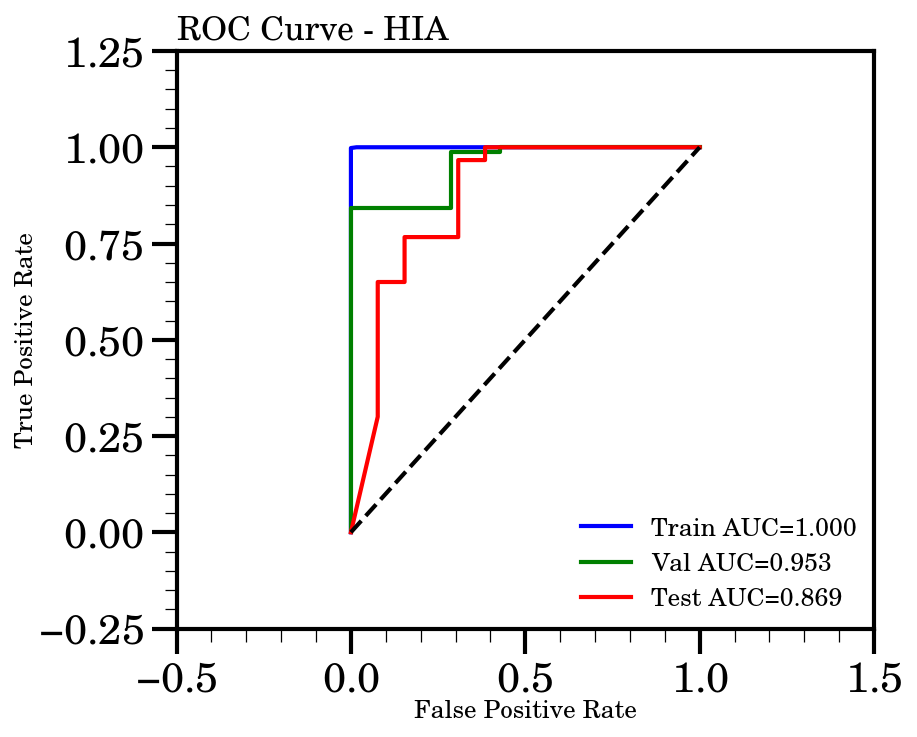

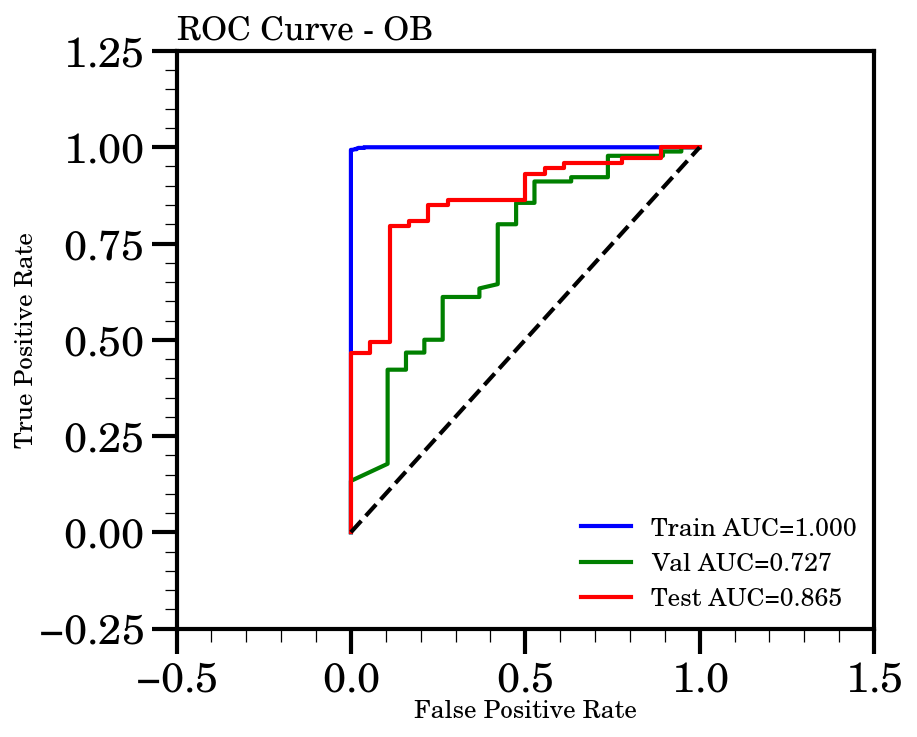

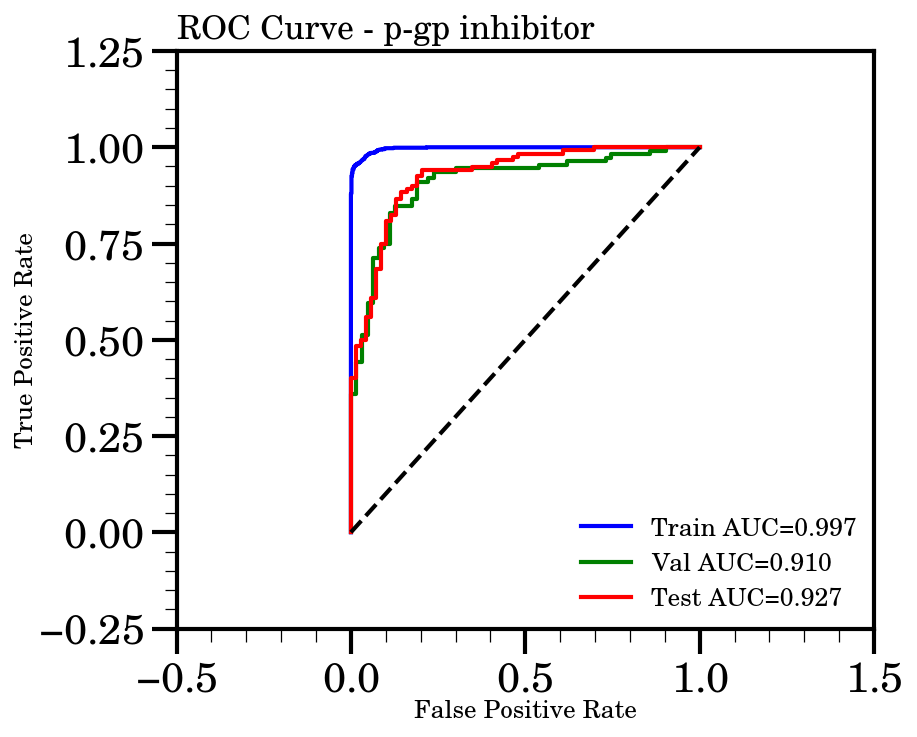

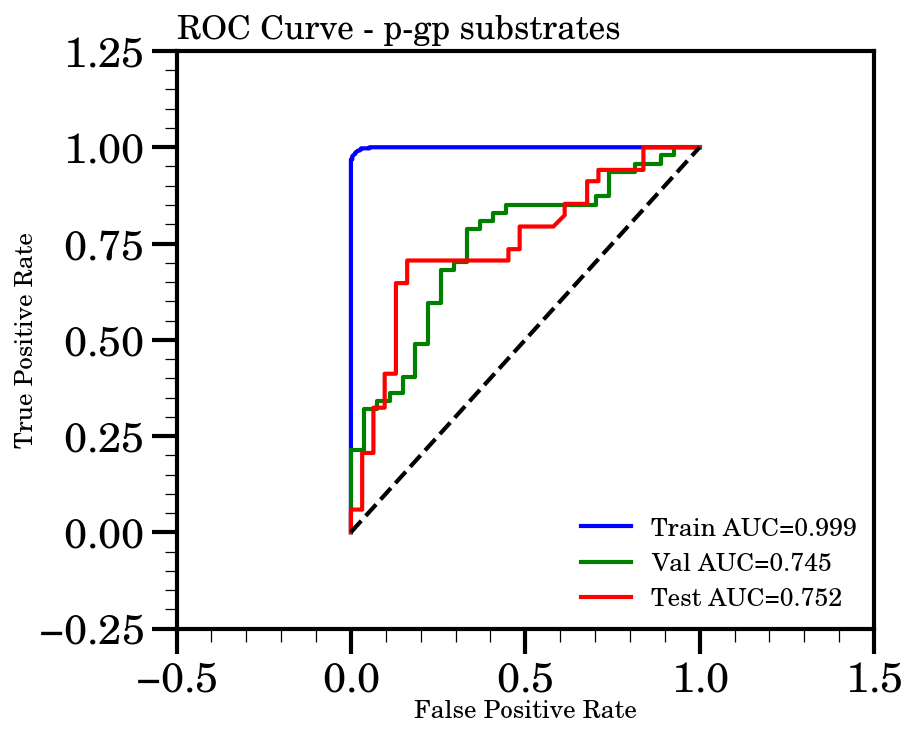

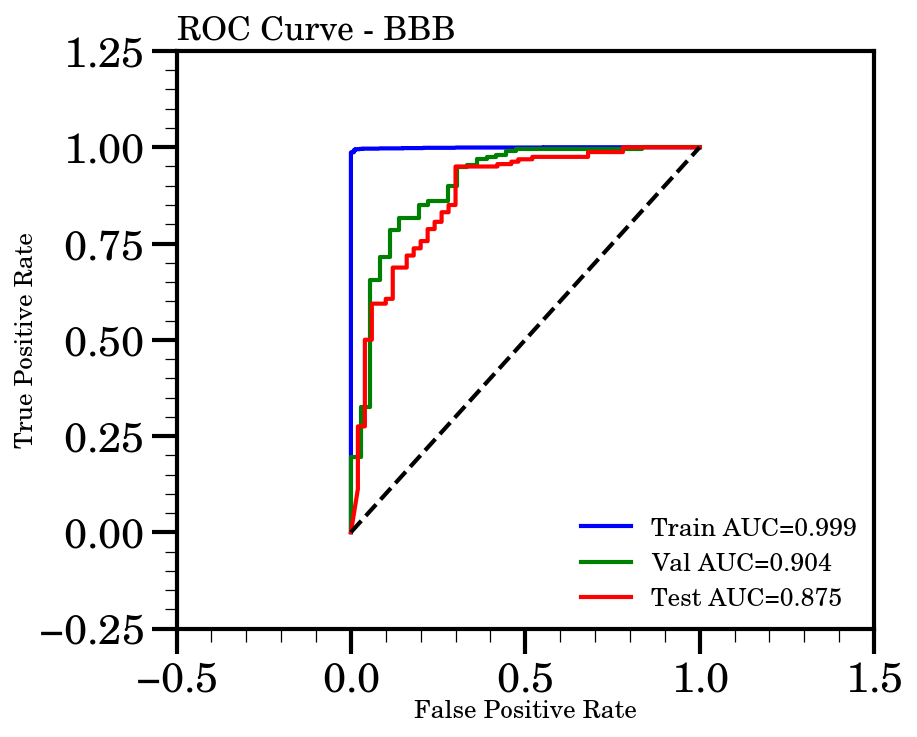

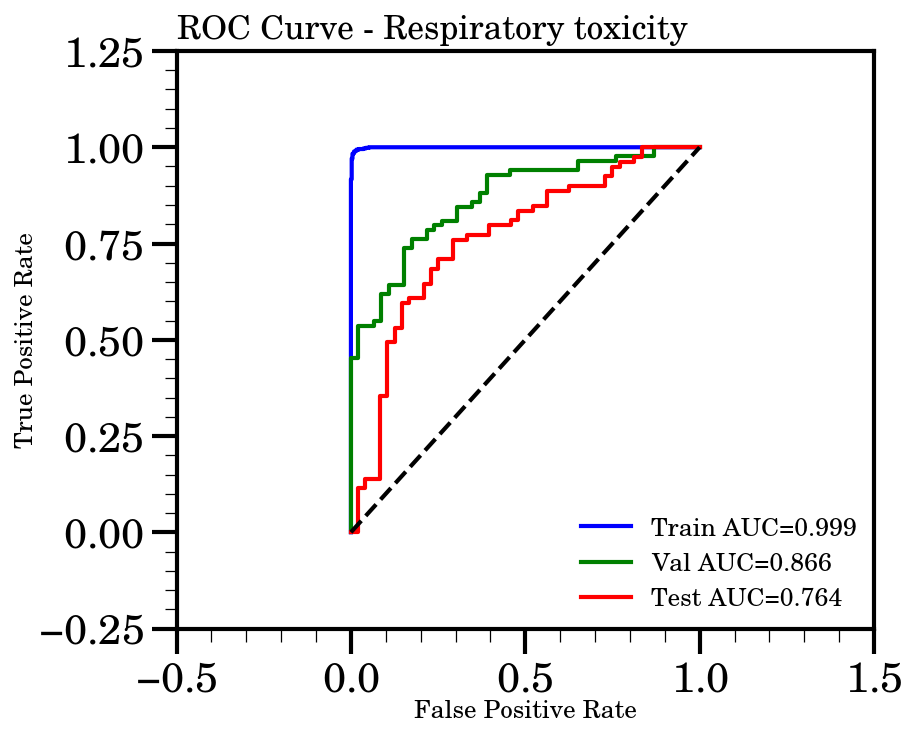

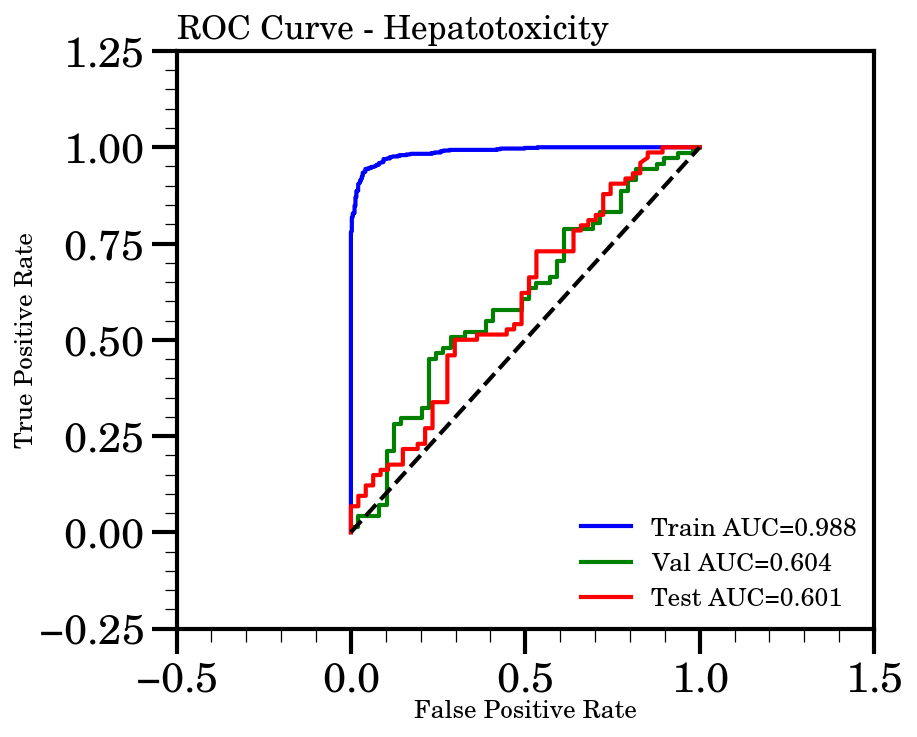

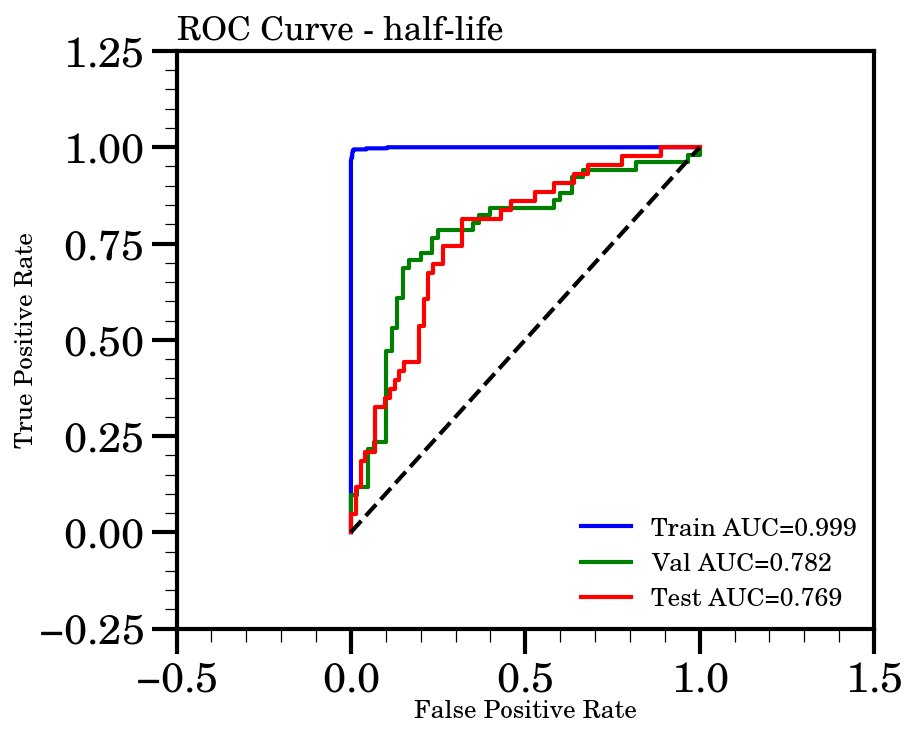

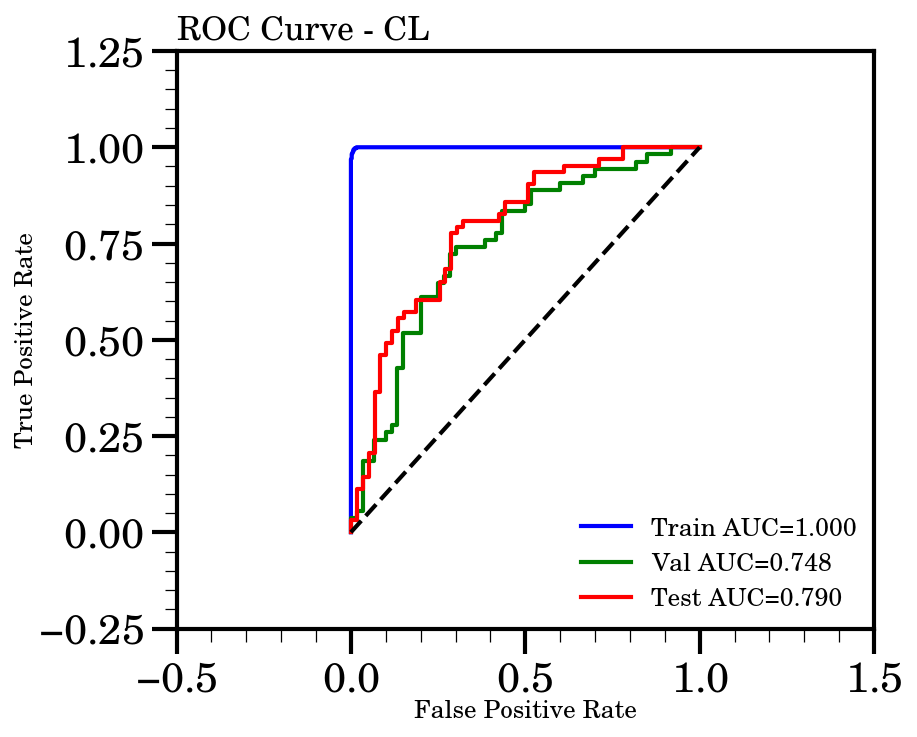

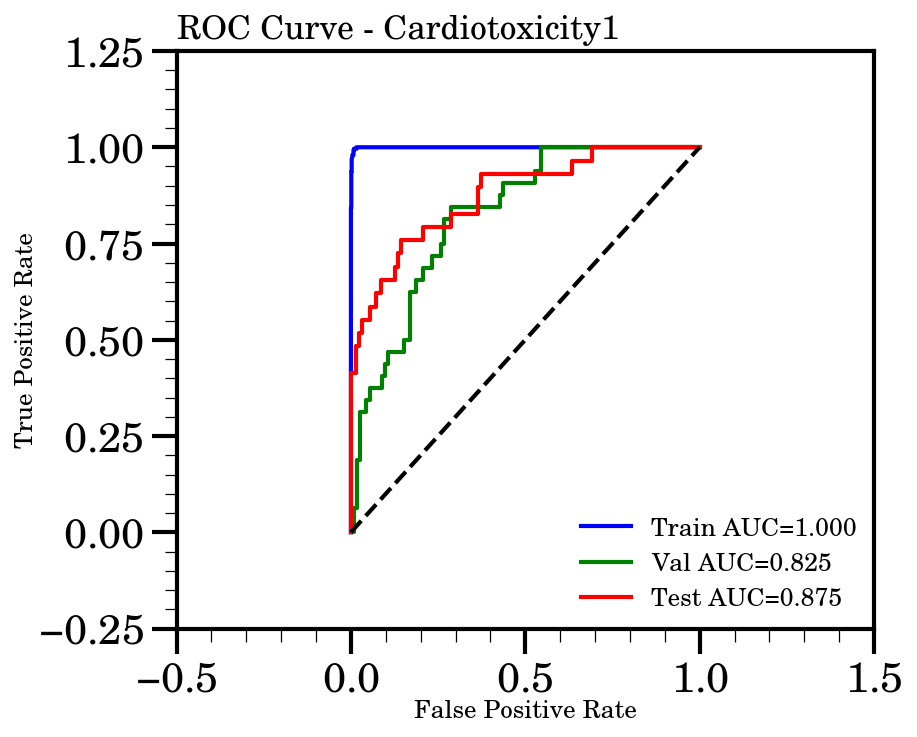

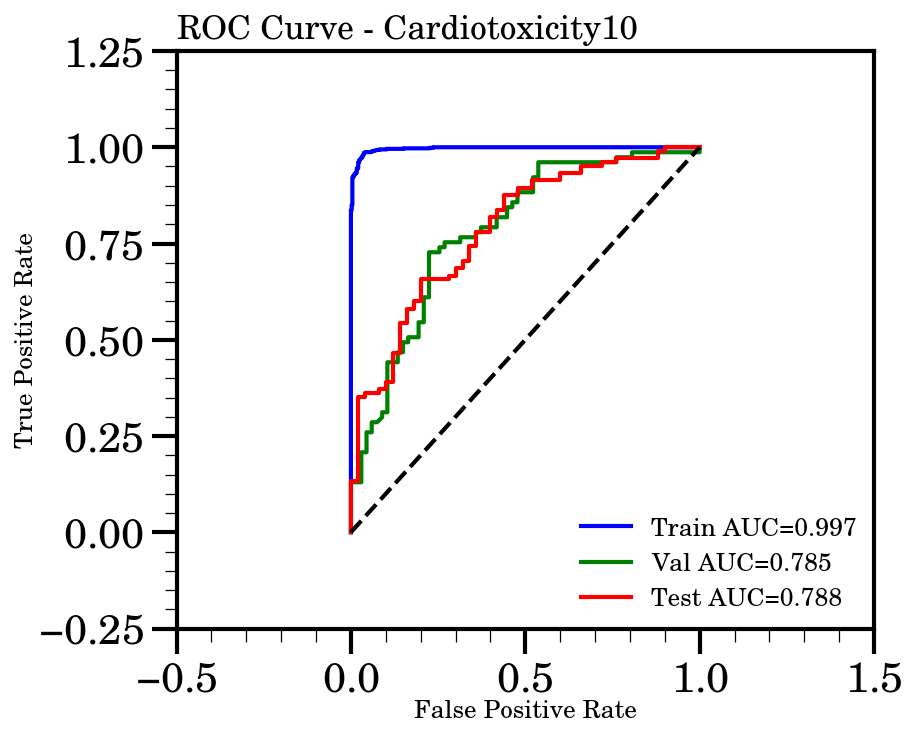

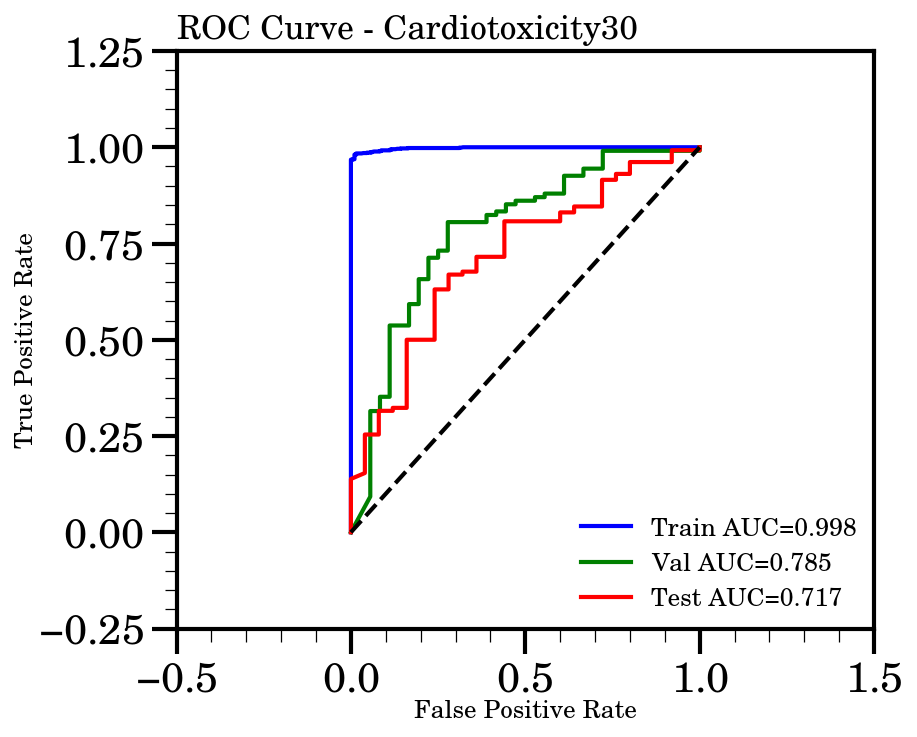

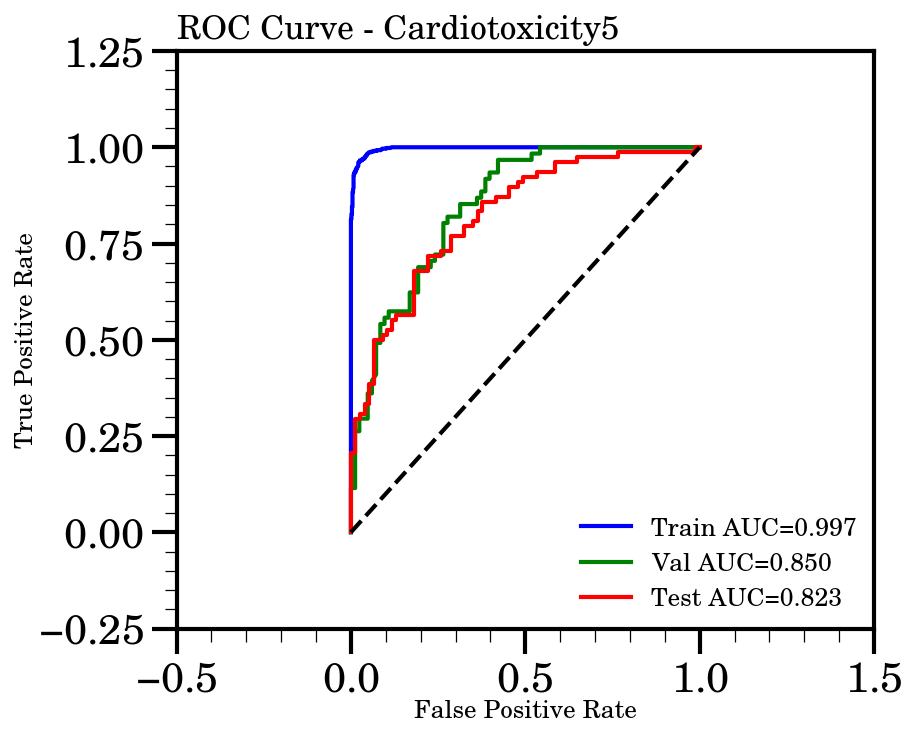

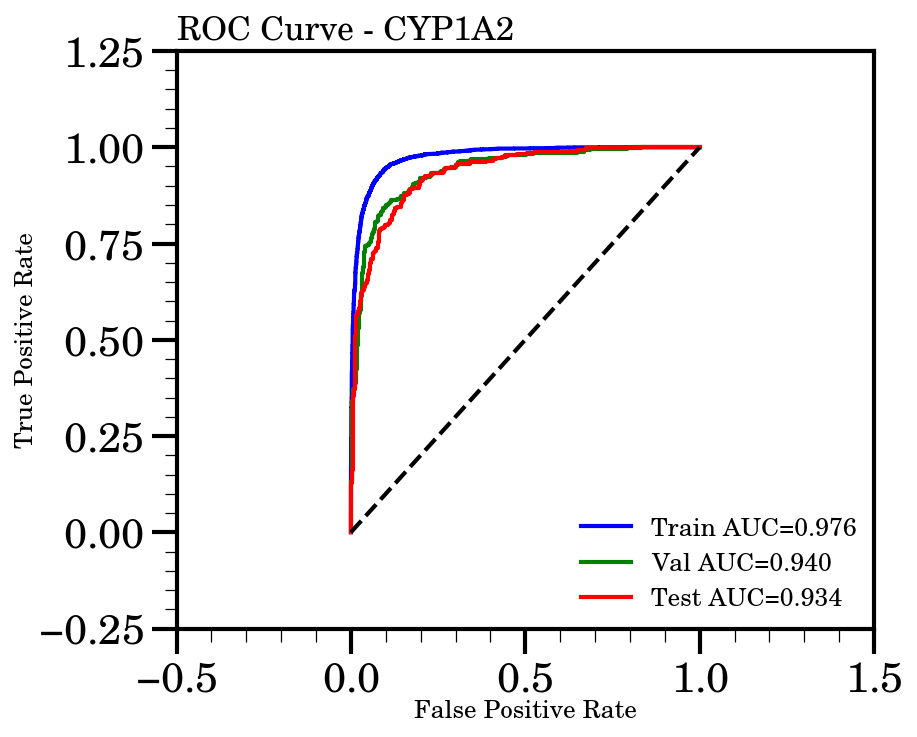

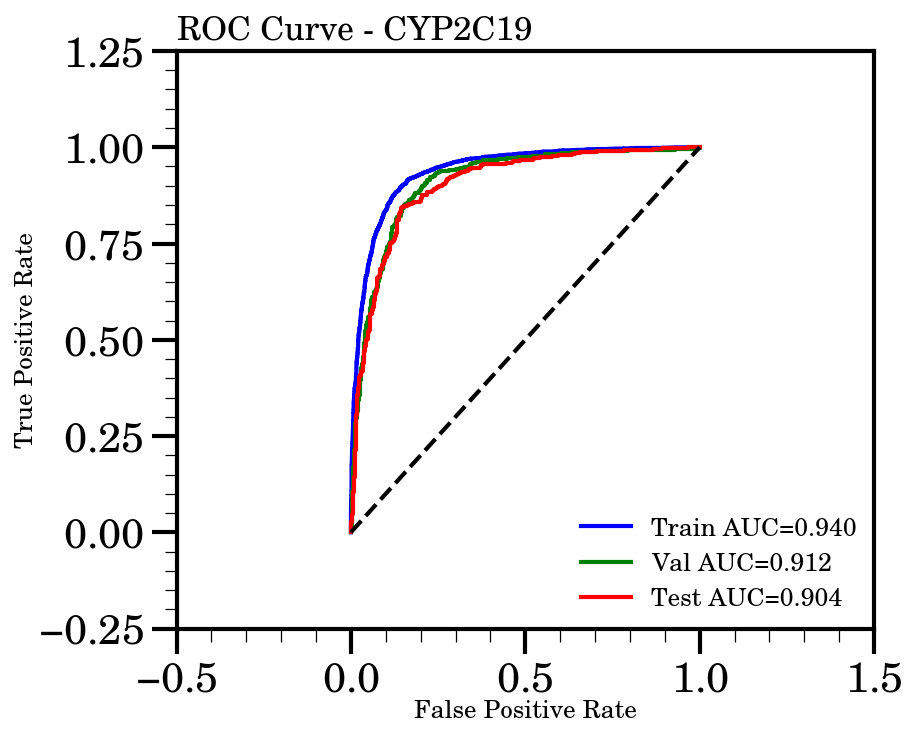

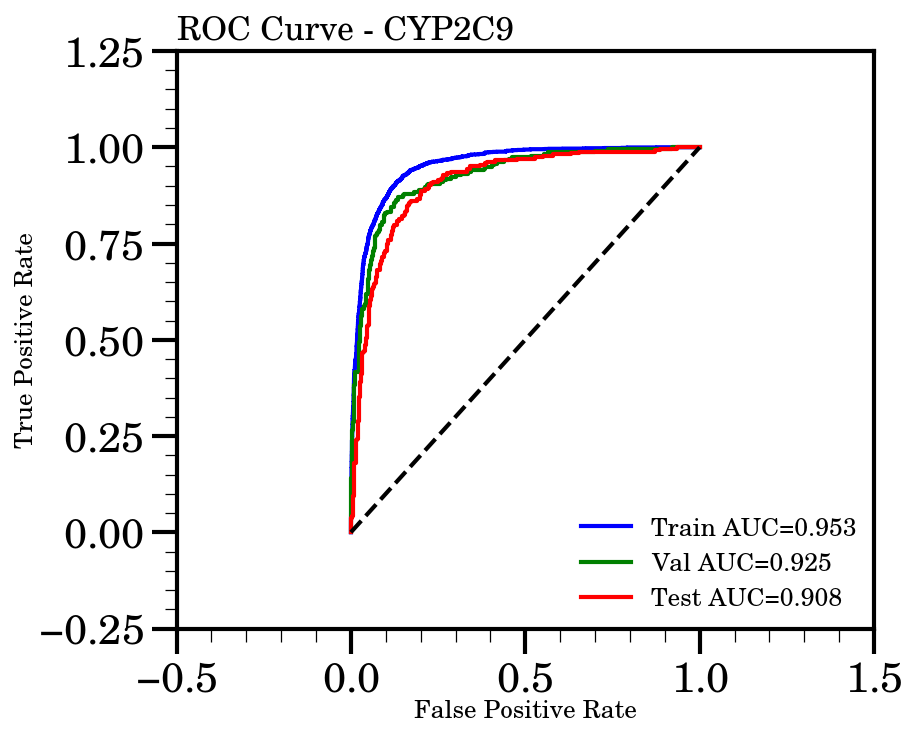

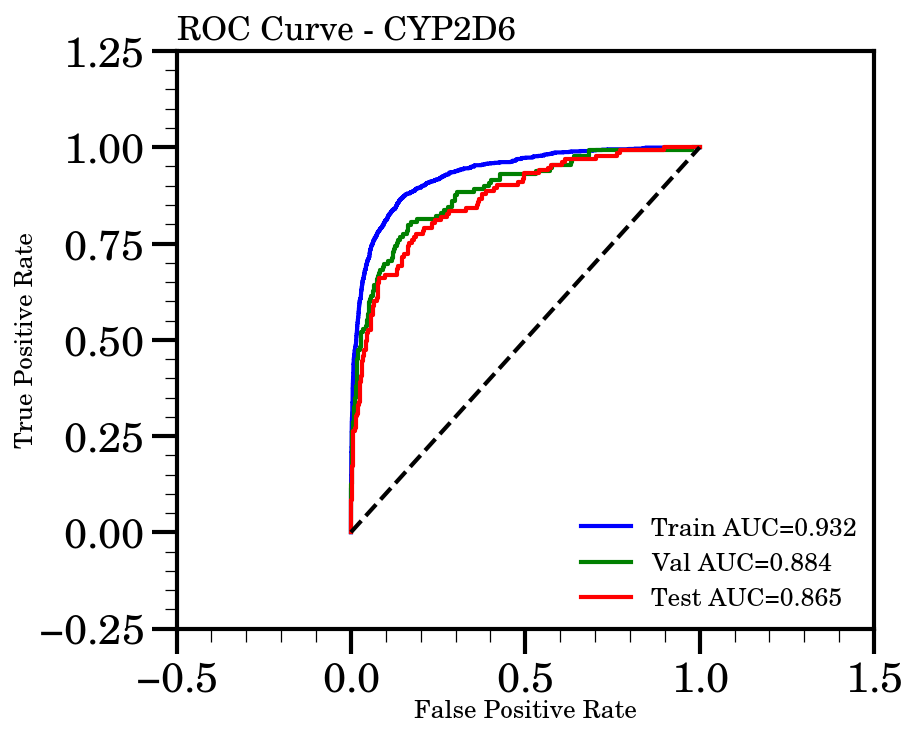

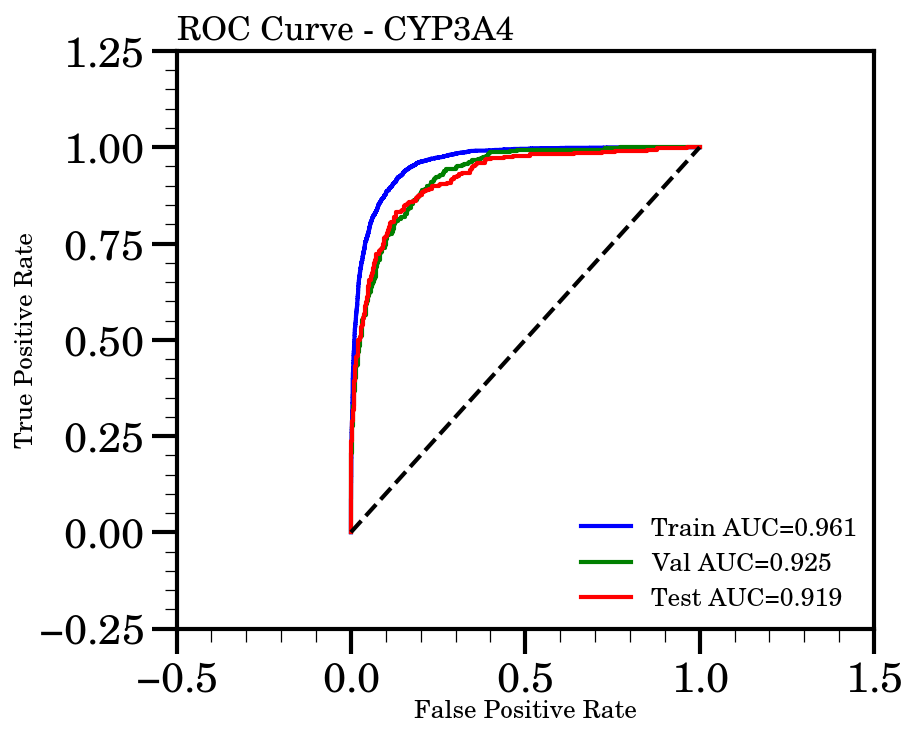

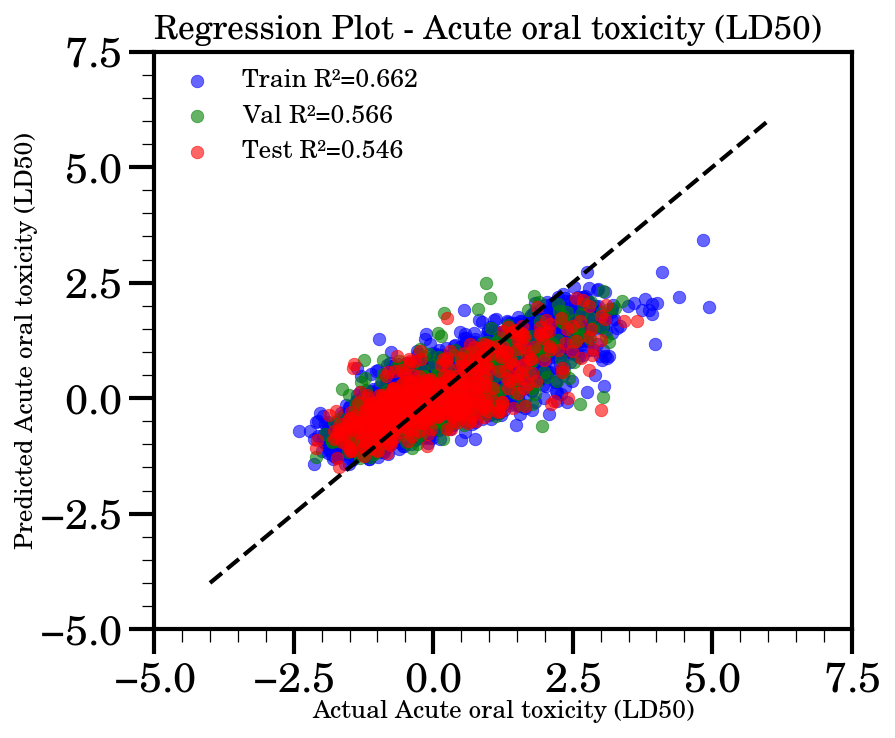

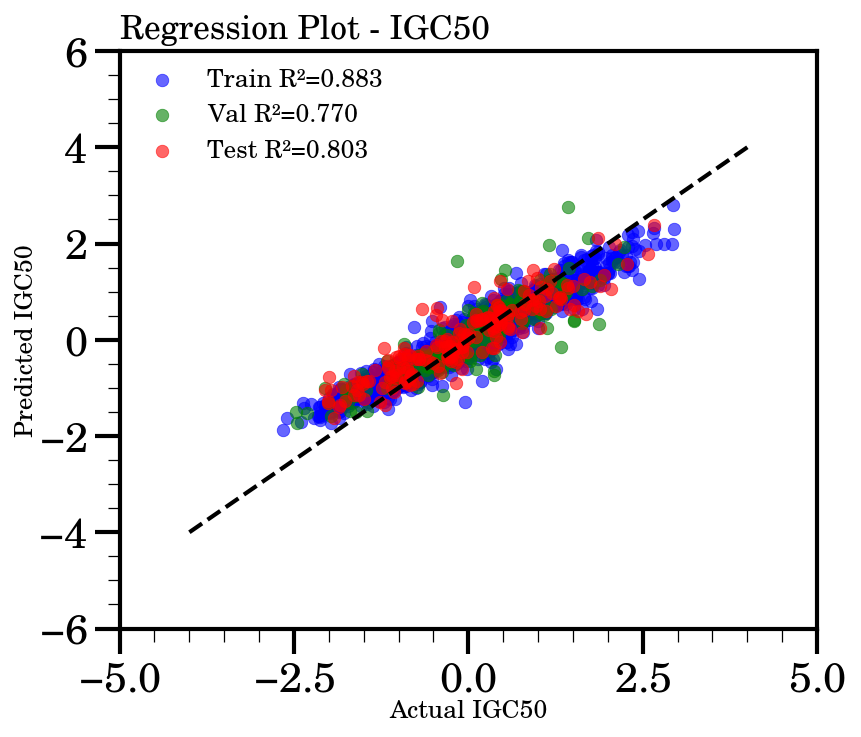

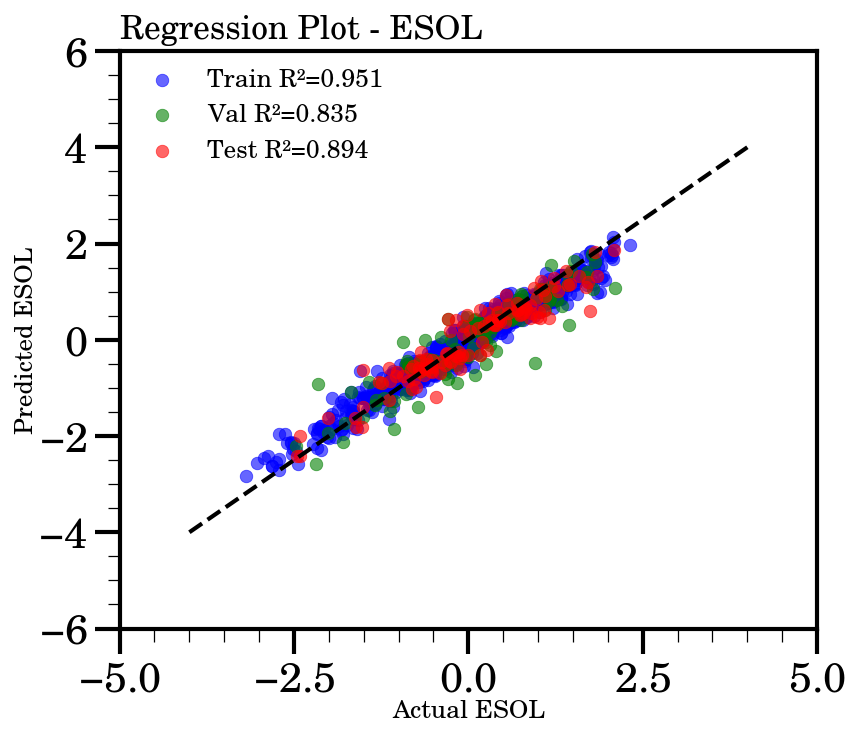

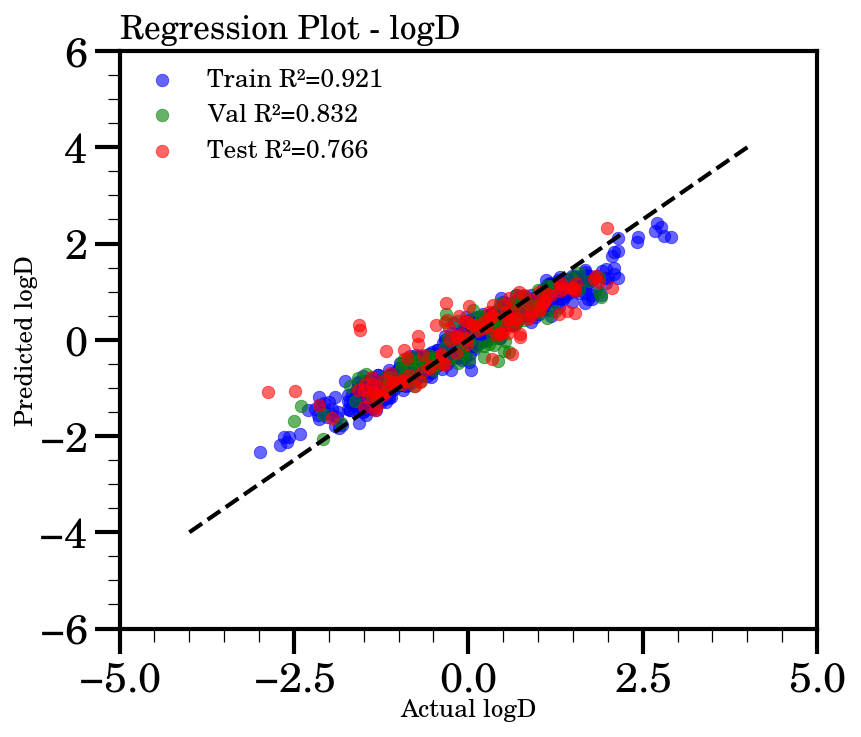

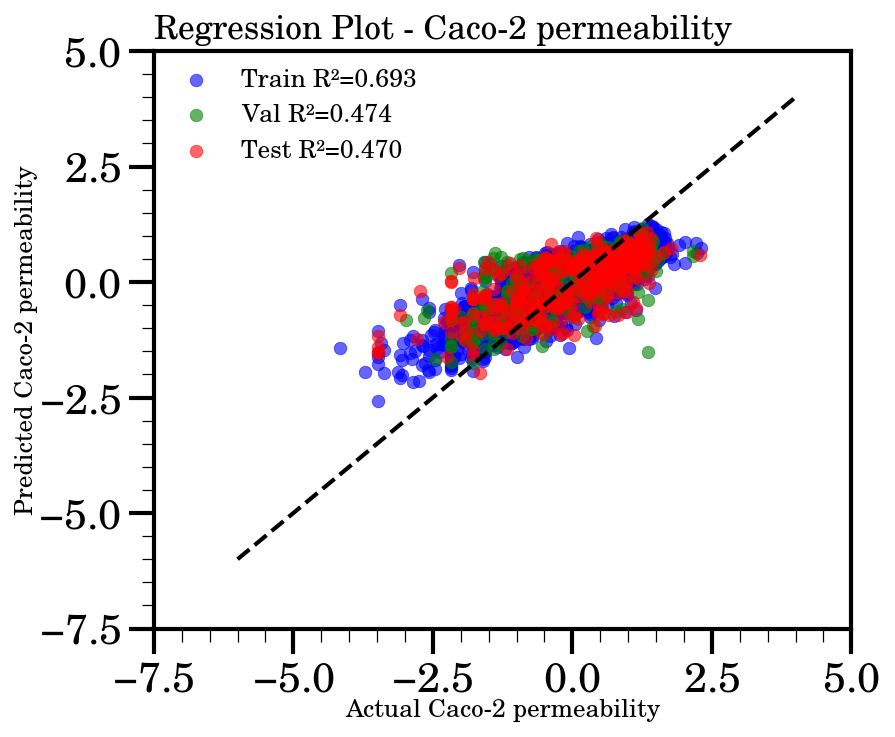

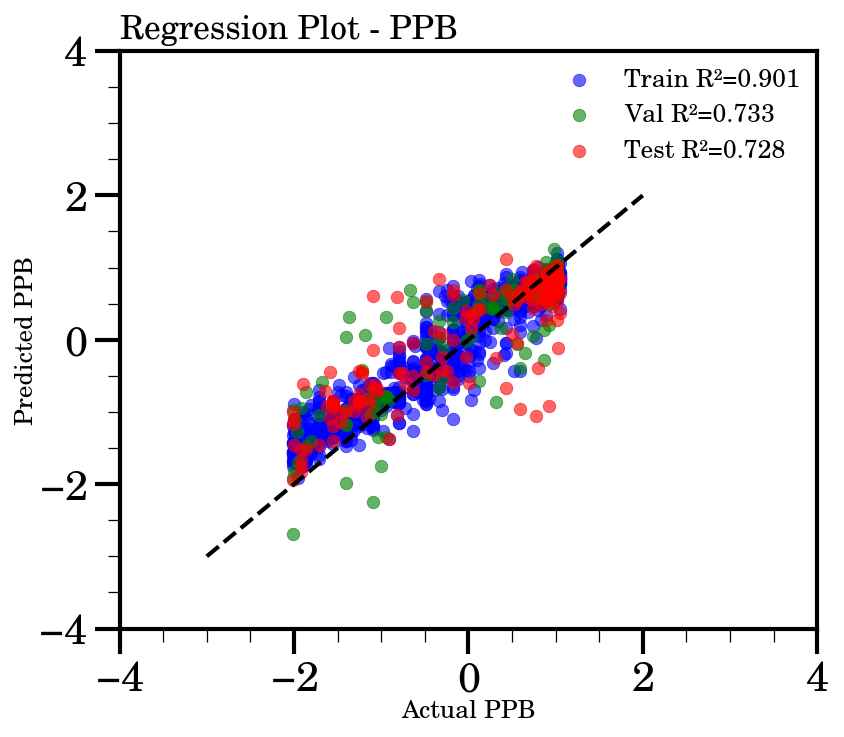

                          Task        Type  Train Score  Val Score  \
0                          HIA      Binary     0.999983   0.953008   
1                           OB      Binary     0.999863   0.726608   
2               p-gp inhibitor      Binary     0.997239   0.910482   
3              p-gp substrates      Binary     0.999477   0.745469   
4                          BBB      Binary     0.998944   0.903611   
5         Respiratory toxicity      Binary     0.999465   0.865683   
6               Hepatotoxicity      Binary     0.987855   0.604197   
7                    half-life      Binary     0.999482   0.782026   
8                           CL      Binary     0.999830   0.748457   
9              Cardiotoxicity1      Binary     0.999604   0.824777   
10            Cardiotoxicity10      Binary     0.996729   0.785327   
11            Cardiotoxicity30      Binary     0.997895   0.784979   
12             Cardiotoxicity5      Binary     0.996791   0.850188   
13                  

In [25]:
from evaluator import MultiTaskEvaluator
evaluator = MultiTaskEvaluator(label, binary, benchmark)
evaluator.evaluate(
    train_pred=training_predictions,
    train_label=train_label,
    val_pred=validation_predictions,
    val_label=val_label,
    test_pred=test_predictions,
    test_label=test_label
)
results_df = evaluator.get_results_table()
print(results_df)
